In [1]:
################################
# Load modules                 #
################################

import numpy as np
import matplotlib.pyplot as plt
import pickle

from model import Model
from simulation import FDTD_sim, extend_domain
from sources import *
from analysis import SimulationResultAnalyser, get_dB_response, get_frequency_response
from io_util import load_from_file, save_to_file

c:\Users\buijs\Documents\TUDelft\Masters Thesis\MEP_refactored\.venv\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
###################################
# Load SimulationResult from file #
###################################

result_loaded = load_from_file()
if result_loaded is not None:
    result = result_loaded
    
    if result.sources[0].__class__.__name__ == "ParametricSource":
        delta_f = abs(result.sources[0].frequency1 - result.sources[0].frequency2)
    
print(result.model)
print(result.sources[0])

print(result.p.shape)
print(f"Size of result.p: {result.p.nbytes/1e6:.2f} MB")

Model:
  nr=700
  nz=2000
  dr=0.008 m
  dz=0.008 m
  nt=7000
  dt=1.7e-06 s
  domain_r=3.984 m
  domain_z=12.8 m
  pml_width=200 / 1.6 m
Source:
  ir=0
  iz=205
  iwidth=75 / 0.6 m
  pulse_length=2000
  max_freq=11500.0

(3501, 249, 800)
Size of result.p: 2789.60 MB


In [3]:
###################################
# Initialize analyser object      #
###################################

analyser = SimulationResultAnalyser(result)

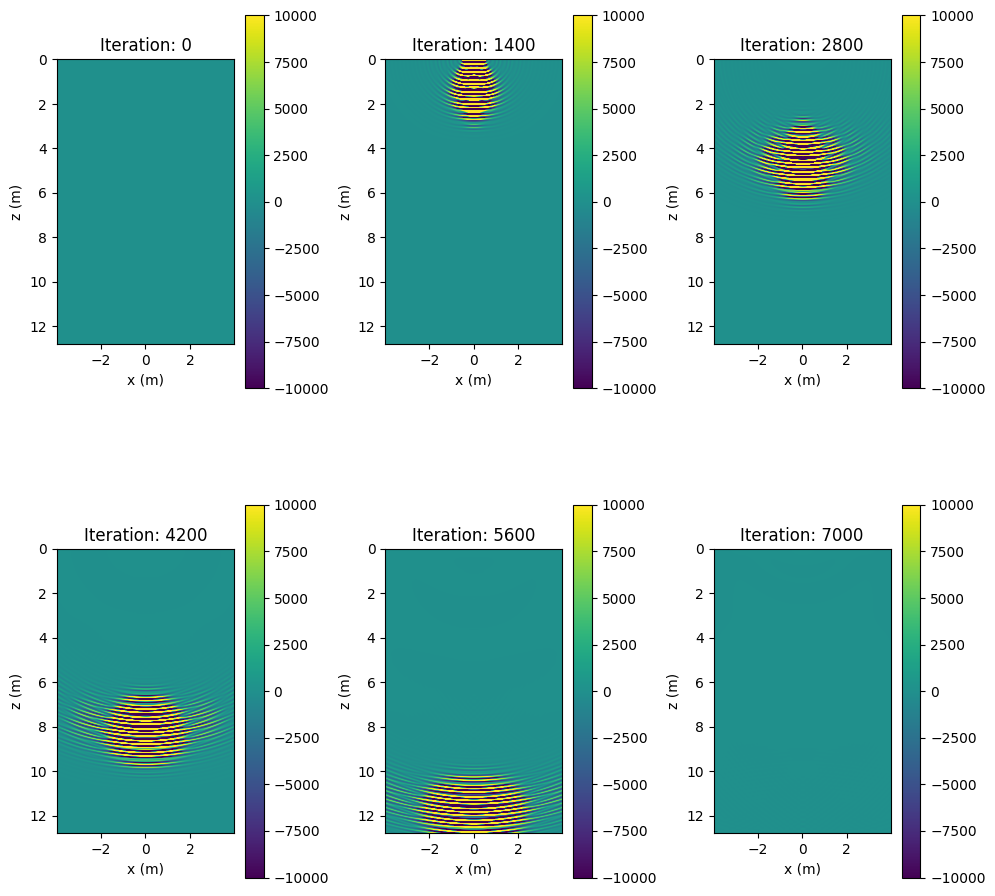

In [4]:
################################################
# Plot pressure field at 6 different timesteps #
################################################

vlimit = 1e4
# plt.rcParams.update({"font.size": 10})
analyser.plot_snapshots(vlimit=vlimit, mirror=True)

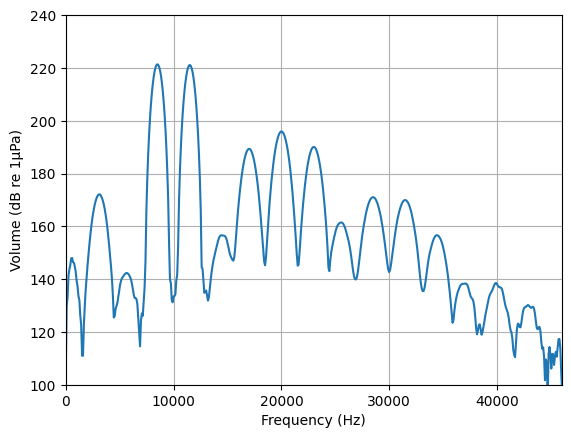

In [5]:
##############################################
# Plot frequency response at specified depth #
##############################################

depth = 6  # m
ymin = 100
ymax = 240

r_index = 0
z_index = int(depth/result.model.dz/result.subsample_space)

plt.plot(*get_dB_response(np.pad(result.p[:, r_index, z_index], (0,0)), 
                          result.model.dt*result.subsample_time, 
                          result.sources[0].scaling_factor*result.subsample_time, 
                          normalize=False))


plt.xlabel("Frequency (Hz)")
# plt.ylabel("Normalized volume (dB)")
plt.ylabel("Volume (dB re 1\u00B5Pa)")

plt.xlim(0,4*result.sources[0].max_freq)
plt.ylim(ymin,ymax)
# plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
plt.grid()
plt.show()

lp_filter: Array too large for GPU. Splitting domain.


100%|██████████| 8403/8403 [03:01<00:00, 46.21it/s]


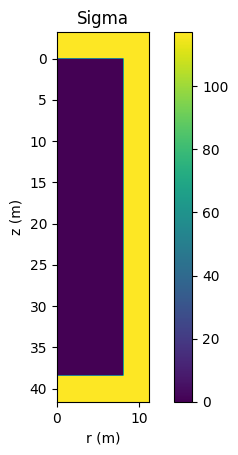

In [6]:
############################
# Perform domain extension #
############################

# The value of extend_from is the index of the time step to start the domain extension
# The whole sound pulse should be visible in the domain in order to get correct results.
# The 6 snapshots plotted earlier can be used for this.
extend_from = 4200

result = extend_domain(result, 
                       extend_from=extend_from//result.subsample_time, 
                       depth_multiplier=3, 
                       width_multiplier=2, 
                       cutoff=2*delta_f, 
                       additional_subsampling=3)

analyser = SimulationResultAnalyser(result)

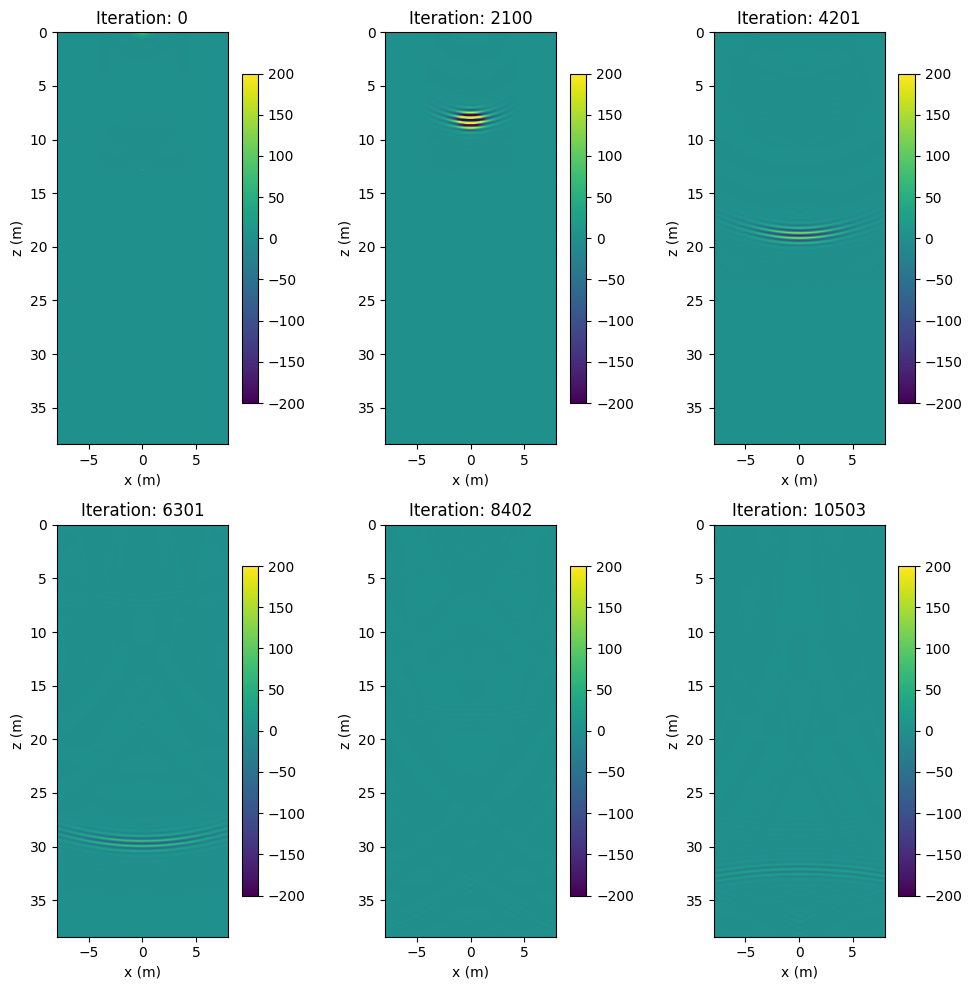

In [7]:
################################################
# Plot pressure field at 6 different timesteps #
################################################

vlimit = 1e3
plt.rcParams.update({"font.size": 10})
analyser.plot_snapshots(vlimit=vlimit/5, mirror=True)

In [9]:
###################################
# Compute beam profile            #
###################################

frequencies, lobes_array = analyser.get_lobes_all(scaling_factor=result.sources[0].scaling_factor, subsample_space=1)
# frequencies, lobes_array = analyser.get_lobes_all_split(scaling_factor=result.sources[0].scaling_factor, subsample_space=3)

Array too large for GPU. Setting subsample to 6.


Text(0, 0.5, 'z (m)')

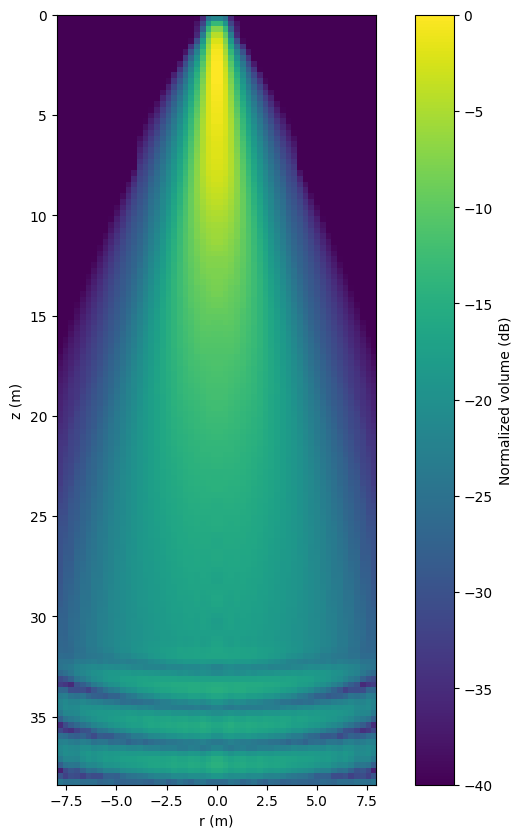

In [10]:
###########################
# Plot beam profile       #
###########################

freq_to_plot = 1*delta_f
# freq_to_plot = result.sources[0].frequency1
# freq_to_plot = 3e3

normalized = True
vmin = -40
vmax = 0

# Select frequency to plot
idx = np.argmin(np.abs(frequencies - freq_to_plot))
lobes_selection = lobes_array[idx]

# Compute dB values
lobes_selection = 20*np.log10(lobes_selection/1e-6)
if normalized:
    lobes_selection -= lobes_selection.max()

# Mirror over z-axis
lobes_selection_mirrored = np.concatenate([np.flip(lobes_selection, axis=0), lobes_selection], axis=0)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(lobes_selection_mirrored.T, extent=[-result.model.nrd * result.model.dr, result.model.nrd * result.model.dr, result.model.nzd * result.model.dz, 0], vmin=vmin, vmax=vmax)
cbar = plt.colorbar()
cbar.set_label("Normalized volume (dB)")
plt.xlabel("r (m)")
plt.ylabel("z (m)")

# print(lobes_selection.T[:,0])

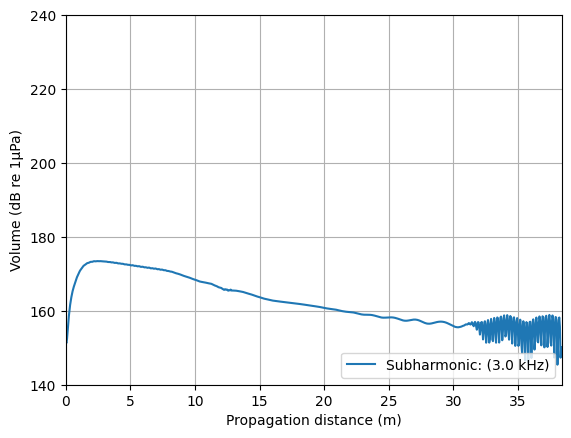

In [11]:
###################################
# Plot harmonic progression       #
###################################

if result.sources[0].__class__.__name__ == "ParametricSource":
    include_subharmonic = True
    delta_f = abs(result.sources[0].frequency1 - result.sources[0].frequency2)
else:
    include_subharmonic = False
    delta_f = 0

# Calculate harmonic progression
distances, harmonic_progression_array, harmonics = analyser.harmonic_progression(num_harmonics=0,
                                                         r_start=0,
                                                         z_start=0,
                                                         angle=0,
                                                         include_subharmonic=include_subharmonic,
                                                         subharmonic_freq=delta_f,
                                                         scaling_factor = result.sources[0].scaling_factor*result.subsample_time,
                                                         normalize=False)

# Plot harmonic progression
if include_subharmonic:
    plt.plot(distances, harmonic_progression_array[0], label=f"Subharmonic: ({delta_f/1e3} kHz)")
    for i in range(1, harmonic_progression_array.shape[0]):
        plt.plot(distances, harmonic_progression_array[i], label=f"Harmonic {i}: ({harmonics[i]/1e3} kHz)")
else:
    for i in range(harmonic_progression_array.shape[0]):
        plt.plot(distances, harmonic_progression_array[i], label=f"Harmonic {i+1}: ({harmonics[i]/1e3} kHz)")


# Set plot parameters
plt.xlabel("Propagation distance (m)")
plt.ylabel("Volume (dB re 1\u00B5Pa)")
plt.xlim(0, result.model.nzd*result.model.dz)
plt.ylim(140, 240)
plt.grid()
# plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.legend(loc="lower right")
plt.show()

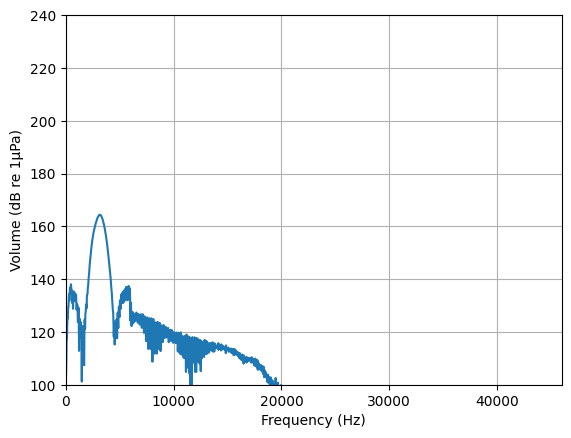

In [12]:
##############################################
# Plot frequency response at specified depth #
##############################################

depth = 15  # m
ymin = 100
ymax = 240

r_index = 0
z_index = int(depth/result.model.dz/result.subsample_space)

plt.plot(*get_dB_response(np.pad(result.p[:, r_index, z_index], (0,0)), 
                          result.model.dt*result.subsample_time, 
                          result.sources[0].scaling_factor*result.subsample_time, 
                          normalize=False))


plt.xlabel("Frequency (Hz)")
# plt.ylabel("Normalized volume (dB)")
plt.ylabel("Volume (dB re 1\u00B5Pa)")

plt.xlim(0,4*result.sources[0].max_freq)
plt.ylim(ymin,ymax)
# plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
plt.grid()
plt.show()

In [14]:
###################################
# Save SimulationResult to file   #
###################################

save_to_file(result)